# XGBoost Local Training - Customer Churn

This notebook demonstrates XGBoost training locally without SageMaker, using the same customer churn dataset from the SageMaker examples.

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## Load and Prepare Data

We'll use the same customer churn dataset preprocessing as the SageMaker examples.

In [13]:
# Load the customer churn dataset
print("Loading customer churn dataset...")
df = pd.read_csv('churn.csv.bz2', compression='bz2')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nTarget column 'Churn?' values: {df['Churn?'].unique()}")
print(f"Churn rate: {(df['Churn?'] == 'True.').mean():.2%}")

# Basic dataset info
print(f"\nDataset info:")
print(f"- Total samples: {len(df)}")
print(f"- Features: {df.shape[1] - 1}")  # Minus target column
print(f"- Missing values: {df.isnull().sum().sum()}")
print(f"- Churned customers: {(df['Churn?'] == 'True.').sum()}")
print(f"- Retained customers: {(df['Churn?'] == 'False.').sum()}")

Loading customer churn dataset...
Dataset shape: (5000, 21)
Columns: ['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

First 5 rows:
  State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    PA             163        806  403-2562         no        yes   
1    SC              15        836  158-8416        yes         no   
2    MO             131        777  896-6253         no        yes   
3    WY              75        878  817-5729        yes        yes   
4    WY             146        878  450-4942        yes         no   

   VMail Message   Day Mins  Day Calls  Day Charge  ...  Eve Calls  \
0            300   8.162204          3    7.579174  ...          4   
1              0  10.018993          4    4.226289  ...          0 

## Data Preprocessing

Same preprocessing steps as the SageMaker example:
1. Handle categorical variables
2. Remove correlated features
3. Create target variable

In [4]:
# Cast Area Code to non-numeric (categorical)
df["Area Code"] = df["Area Code"].astype(object)

# One-hot encode categorical features
model_data = pd.get_dummies(df)
print(f"After one-hot encoding: {model_data.shape}")

# Move target column to the beginning (XGBoost convention)
target_col = "Churn?_True."
model_data = pd.concat([
    model_data[target_col],
    model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)
], axis=1)

print(f"Final dataset shape: {model_data.shape}")
print(f"Features: {model_data.columns.tolist()[1:6]}...")  # Show first 5 features
print(f"Target distribution: {model_data[target_col].value_counts()}")

After one-hot encoding: (5000, 5104)
Final dataset shape: (5000, 5103)
Features: ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge']...
Target distribution: Churn?_True.
False    2502
True     2498
Name: count, dtype: int64


In [6]:
# Split data into train and validation datasets
train_data, validation_data = train_test_split(model_data, test_size=0.33, random_state=42, stratify=model_data[target_col])

# Further split validation into validation and test
validation_data, test_data = train_test_split(validation_data, test_size=0.33, random_state=42, stratify=validation_data[target_col])

print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
print(f"Test set: {test_data.shape}")

# Prepare data for XGBoost
X_train = train_data.drop(target_col, axis=1)
y_train = train_data[target_col]

X_val = validation_data.drop(target_col, axis=1)
y_val = validation_data[target_col]

X_test = test_data.drop(target_col, axis=1)
y_test = test_data[target_col]

print(f"\nFeature columns: {X_train.shape[1]}")
print(f"Training target distribution: {y_train.value_counts()}")

Training set: (3350, 5103)
Validation set: (1105, 5103)
Test set: (545, 5103)

Feature columns: 5102
Training target distribution: Churn?_True.
False    1676
True     1674
Name: count, dtype: int64


## XGBoost Training

Now we'll train XGBoost using the native Python API, showing both the high-level sklearn-style interface and the lower-level XGBoost API.

In [8]:
# Method 1: XGBoost with sklearn-style API (easiest)
print("=== Training with XGBoost sklearn-style API ===")

model_sklearn = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

# Fit with evaluation set (evaluation sets will be named validation_0, validation_1, etc.)
model_sklearn.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# Predictions
y_pred_sklearn = model_sklearn.predict(X_test)
y_proba_sklearn = model_sklearn.predict_proba(X_test)[:, 1]

print(f"\nSklearn-style API Results:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_sklearn):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_proba_sklearn):.4f}")

=== Training with XGBoost sklearn-style API ===
[0]	validation_0-auc:0.93315	validation_1-auc:0.91929
[1]	validation_0-auc:0.94690	validation_1-auc:0.93072
[2]	validation_0-auc:0.95913	validation_1-auc:0.94910
[3]	validation_0-auc:0.96421	validation_1-auc:0.95759
[4]	validation_0-auc:0.96847	validation_1-auc:0.96197
[5]	validation_0-auc:0.97017	validation_1-auc:0.96374
[6]	validation_0-auc:0.97377	validation_1-auc:0.96611
[7]	validation_0-auc:0.97595	validation_1-auc:0.96848
[8]	validation_0-auc:0.97984	validation_1-auc:0.97149
[9]	validation_0-auc:0.98171	validation_1-auc:0.97376
[10]	validation_0-auc:0.98389	validation_1-auc:0.97577
[11]	validation_0-auc:0.98511	validation_1-auc:0.97627
[12]	validation_0-auc:0.98602	validation_1-auc:0.97752
[13]	validation_0-auc:0.98726	validation_1-auc:0.97832
[14]	validation_0-auc:0.98806	validation_1-auc:0.97821
[15]	validation_0-auc:0.98918	validation_1-auc:0.97956
[16]	validation_0-auc:0.98957	validation_1-auc:0.97972
[17]	validation_0-auc:0.989

In [9]:
# Method 2: Native XGBoost API (more control)
print("\n=== Training with Native XGBoost API ===")

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters (same as sklearn version above)
params = {
    'max_depth': 5,
    'eta': 0.2,  # learning_rate
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

# Training with validation monitoring
evallist = [(dtrain, 'train'), (dval, 'validation')]
num_rounds = 100

model_native = xgb.train(
    params, 
    dtrain, 
    num_rounds, 
    evallist,
    verbose_eval=10  # Print every 10 rounds
)

# Predictions
y_proba_native = model_native.predict(dtest)
y_pred_native = (y_proba_native > 0.5).astype(int)

print(f"\nNative API Results:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_native):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_proba_native):.4f}")


=== Training with Native XGBoost API ===


/Users/machiel/Development/crystalline/sagemaker/corelab/.venv/lib/python3.13/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.93315	validation-auc:0.91929
[10]	train-auc:0.98389	validation-auc:0.97577
[20]	train-auc:0.99097	validation-auc:0.98068
[30]	train-auc:0.99523	validation-auc:0.98481
[40]	train-auc:0.99716	validation-auc:0.98742
[50]	train-auc:0.99823	validation-auc:0.98857
[60]	train-auc:0.99930	validation-auc:0.98916
[70]	train-auc:0.99968	validation-auc:0.98967
[80]	train-auc:0.99989	validation-auc:0.99036
[90]	train-auc:0.99997	validation-auc:0.99093
[99]	train-auc:0.99999	validation-auc:0.99105

Native API Results:
Test Accuracy: 0.9560
Test AUC: 0.9945


## Model Evaluation and Analysis

=== Detailed Model Evaluation ===
Using sklearn-style model for evaluation

Classification Report (sklearn-style model):
              precision    recall  f1-score   support

       False       0.96      0.95      0.96       273
        True       0.95      0.96      0.96       272

    accuracy                           0.96       545
   macro avg       0.96      0.96      0.96       545
weighted avg       0.96      0.96      0.96       545



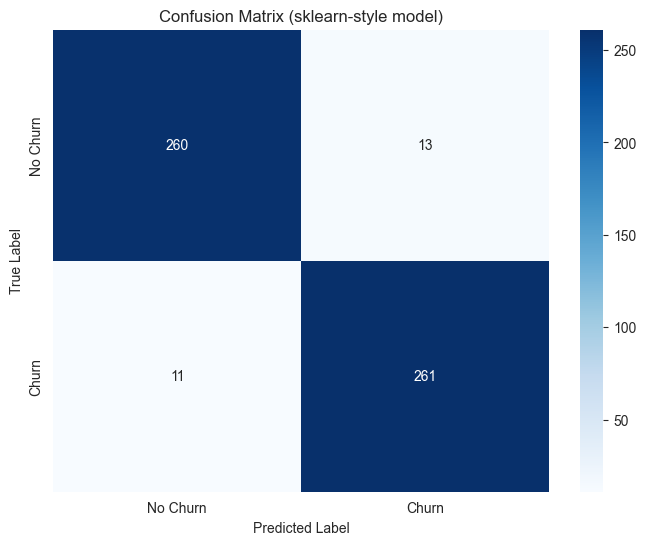

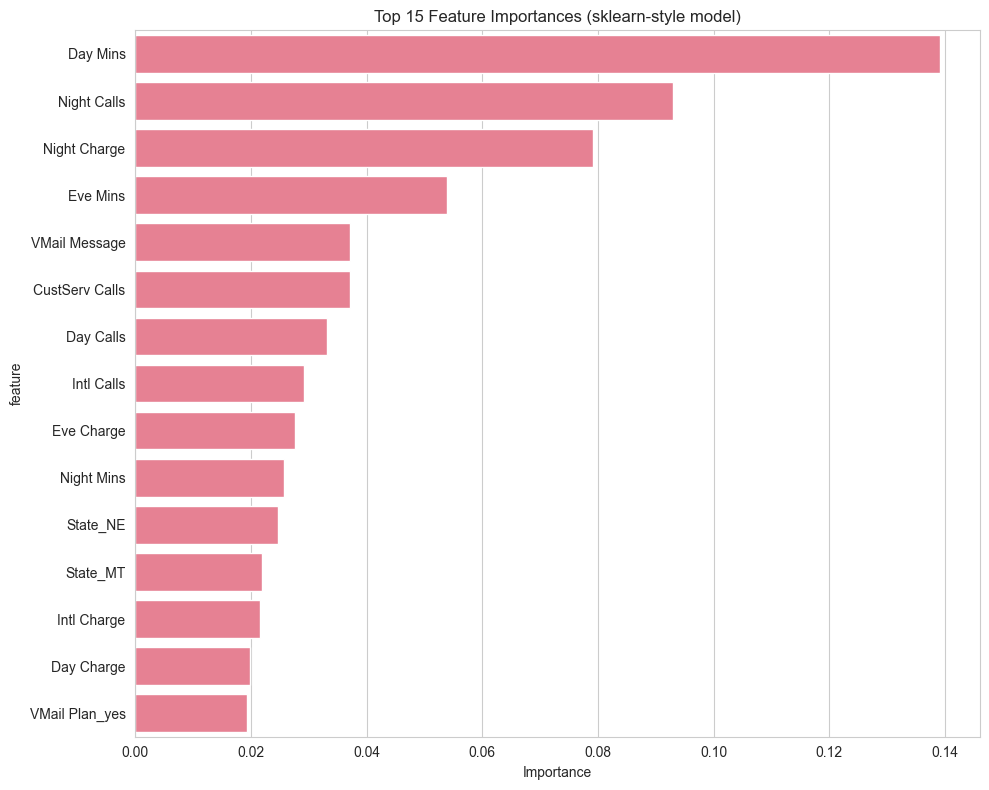


Top 10 Most Important Features:
           feature  importance
2         Day Mins    0.139074
9      Night Calls    0.092913
10    Night Charge    0.079131
5         Eve Mins    0.053893
1    VMail Message    0.037169
14  CustServ Calls    0.037146
3        Day Calls    0.033153
12      Intl Calls    0.029235
7       Eve Charge    0.027623
8       Night Mins    0.025759


In [10]:
# Detailed evaluation - use sklearn model if available, otherwise use native model
print("=== Detailed Model Evaluation ===")

# Check which model is available for evaluation
try:
    # Try to use sklearn model predictions if they exist
    test_predictions = y_pred_sklearn
    test_probabilities = y_proba_sklearn
    eval_model = model_sklearn
    model_type = "sklearn-style"
    print("Using sklearn-style model for evaluation")
except NameError:
    # Fall back to native model if sklearn model failed
    test_predictions = y_pred_native
    test_probabilities = y_proba_native
    eval_model = None  # Native model doesn't have feature_importances_ attribute
    model_type = "native"
    print("Using native XGBoost model for evaluation")

# Classification report
print(f"\nClassification Report ({model_type} model):")
print(classification_report(y_test, test_predictions))

# Confusion matrix
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix ({model_type} model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance (only available for sklearn model)
if model_type == "sklearn-style":
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': eval_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Top 15 Feature Importances (sklearn-style model)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
else:
    # For native model, get feature importance differently
    feature_importance = model_native.get_score(importance_type='weight')
    feature_importance_df = pd.DataFrame(
        list(feature_importance.items()), 
        columns=['feature', 'importance']
    ).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Top 15 Feature Importances (native model)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

## Save Model Locally

We'll save the model in XGBoost's native format, which is what SageMaker uses internally.

In [11]:
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save sklearn-style model if it was successfully trained
sklearn_model_saved = False
try:
    model_sklearn.save_model('models/xgboost_sklearn_model.json')
    print("Saved sklearn-style model to: models/xgboost_sklearn_model.json")
    sklearn_model_saved = True
except (NameError, AttributeError) as e:
    print(f"Sklearn model not available for saving: {e}")
    print("This can happen if the sklearn training failed, but native model should still be available.")

# Save native model (this is the format SageMaker uses)
model_native.save_model('models/xgboost_native_model.json')
print("Saved native model to: models/xgboost_native_model.json")

# Save feature names for later use
import json
with open('models/feature_names.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)
print("Saved feature names to: models/feature_names.json")

# Save model metadata - use available model results
try:
    # Prefer sklearn model results if available
    test_accuracy = float(accuracy_score(y_test, y_pred_sklearn))
    test_auc = float(roc_auc_score(y_test, y_proba_sklearn))
    model_source = "sklearn"
except NameError:
    # Use native model results as fallback
    test_accuracy = float(accuracy_score(y_test, y_pred_native))
    test_auc = float(roc_auc_score(y_test, y_proba_native))
    model_source = "native"

metadata = {
    'model_type': 'XGBoost',
    'n_features': X_train.shape[1],
    'n_classes': 2,
    'target_column': target_col,
    'test_accuracy': test_accuracy,
    'test_auc': test_auc,
    'training_samples': len(X_train),
    'model_source': model_source,  # Track which model provided the results
    'sklearn_saved': sklearn_model_saved,
    'parameters': {
        'max_depth': 5,
        'learning_rate': 0.2,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("Saved model metadata to: models/model_metadata.json")

print(f"\n=== Model files saved successfully! ===")
print(f"Results based on {model_source} model")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Saved sklearn-style model to: models/xgboost_sklearn_model.json
Saved native model to: models/xgboost_native_model.json
Saved feature names to: models/feature_names.json
Saved model metadata to: models/model_metadata.json

=== Model files saved successfully! ===
Results based on sklearn model
Test Accuracy: 0.9560
Test AUC: 0.9945


## Load and Test Saved Model

Demonstrate loading the saved model and making predictions, simulating what would happen in a production environment.

In [ ]:
# Load the saved model
loaded_model = xgb.Booster()
loaded_model.load_model('models/xgboost_native_model.json')

# Load feature names
with open('models/feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load metadata
with open('models/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print("=== Testing Loaded Model ===")
print(f"Model type: {metadata['model_type']}")
print(f"Features: {metadata['n_features']}")
print(f"Training accuracy: {metadata['test_accuracy']:.4f}")
print(f"Training AUC: {metadata['test_auc']:.4f}")

# Test prediction with loaded model
dtest_loaded = xgb.DMatrix(X_test)
y_proba_loaded = loaded_model.predict(dtest_loaded)
y_pred_loaded = (y_proba_loaded > 0.5).astype(int)

# Verify predictions match
print(f"\nLoaded model test accuracy: {accuracy_score(y_test, y_pred_loaded):.4f}")
print(f"Loaded model test AUC: {roc_auc_score(y_test, y_proba_loaded):.4f}")
print(f"Predictions match original model: {np.array_equal(y_pred_native, y_pred_loaded)}")

# Sample prediction
sample_customer = X_test.iloc[0:1]
sample_prediction = loaded_model.predict(xgb.DMatrix(sample_customer))[0]
print(f"\nSample customer churn probability: {sample_prediction:.4f}")
print(f"Sample customer features (first 5): {dict(sample_customer.iloc[0][:5])}")

## Summary

This notebook demonstrates:

1. **Data preprocessing** identical to SageMaker examples
2. **Local XGBoost training** using both sklearn-style and native APIs
3. **Model evaluation** with metrics and visualizations
4. **Model persistence** in XGBoost native format

### Key Differences from SageMaker:

- **No cloud infrastructure** - runs entirely on local machine
- **Direct model access** - no need for endpoints or containers
- **Immediate results** - no waiting for training jobs or deployments
- **Full control** - access to all XGBoost parameters and features

### Next Steps:

- Compare results with SageMaker training
- Experiment with different hyperparameters locally before SageMaker training
- Use this for rapid prototyping and development
- Deploy to SageMaker when ready for production scaling